In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col, avg, sum, window, round
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:


# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/13 15:30:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
# Define the schema for our data (Column names and Datatype for each column)
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic

# initalise a spark object and read the stream of data using the readStream method
# set the format of the streaming source to kafka
# set the kafka topic to retail_transactions (topic is a feed name to which messages are published)
# load the data and store it in the df variable
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [4]:
# Extract and parse the JSON data - convert the json data to strings and add it to a new column 'data'

# selectExpr allows you to select and transform columns using SQL
# CAST(value AS STRING) - SQL expression that set the datatype for the selected column as a string
# withColumn - Pyspark method used to add a or replace a column to the DF, in this case creating a new column named 'data'
# the from_json function takes the json data from the value column of the stream and inserts into the new column
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))


# write the transactions DF to an in memory table called temporary_view_two

# writeStream - write the streaming data to memory, whereas readStream reads streaming data
# set the format to memory
# give the query a name using queryName
# start the streaming query
query = transactions.writeStream \
.format("memory") \
.queryName("temporary_view_three") \
.start()

query.awaitTermination(180)

23/12/13 15:30:29 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-21f601c0-e92c-432a-8a27-70a8825d89f6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/13 15:30:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/13 15:30:31 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [5]:
processed_data = spark.sql("SELECT * FROM temporary_view_three")

# Now you can perform aggregations or other transformations on `processed_data`

In [6]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

transactions = processed_data.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|   Los Angeles|2023-12-13 15:30:32|    P00008|               786|
|   Los Angeles|2023-12-13 15:30:33|    P00001|               633|
|       Phoenix|2023-12-13 15:30:36|    P00031|               119|
|       Houston|2023-12-13 15:30:37|    P00099|               162|
|   Los Angeles|2023-12-13 15:30:39|    P00085|               815|
|   Los Angeles|2023-12-13 15:30:41|    P00012|               767|
|       Houston|2023-12-13 15:30:42|    P00036|              -121|
|  Philadelphia|2023-12-13 15:30:45|    P00068|               154|
|   San Antonio|2023-12-13 15:30:47|    P00098|                73|
|   San Antonio|2023-12-13 15:30:48|    P00100|               388|
|       Houston|2023-12-13 15:30:50|    P00065|               711|
|  Philadelphia|2023-12-13 15:30:53|    P00036|               

Objective: Calculate and add a new column discounted_amount, which is 90% of the transaction_amount.

In [7]:
discounted_df = processed_data.withColumn('discounted_amount', round(col('transaction_amount') *0.9, 2))
discounted_df.show()

+--------------+-------------------+----------+------------------+-----------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+-------------------+----------+------------------+-----------------+
|   Los Angeles|2023-12-13 15:30:32|    P00008|               786|            707.4|
|   Los Angeles|2023-12-13 15:30:33|    P00001|               633|            569.7|
|       Phoenix|2023-12-13 15:30:36|    P00031|               119|            107.1|
|       Houston|2023-12-13 15:30:37|    P00099|               162|            145.8|
|   Los Angeles|2023-12-13 15:30:39|    P00085|               815|            733.5|
|   Los Angeles|2023-12-13 15:30:41|    P00012|               767|            690.3|
|       Houston|2023-12-13 15:30:42|    P00036|              -121|           -108.9|
|  Philadelphia|2023-12-13 15:30:45|    P00068|               154|            138.6|
|   San Antonio|2023-12-13 15:30:47|    P00098|                73

In [8]:
filtered_discounted_df= discounted_df.filter(col('store_location')!="online")
filtered_discounted_df.show()

+--------------+-------------------+----------+------------------+-----------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+-------------------+----------+------------------+-----------------+
|   Los Angeles|2023-12-13 15:30:32|    P00008|               786|            707.4|
|   Los Angeles|2023-12-13 15:30:33|    P00001|               633|            569.7|
|       Phoenix|2023-12-13 15:30:36|    P00031|               119|            107.1|
|       Houston|2023-12-13 15:30:37|    P00099|               162|            145.8|
|   Los Angeles|2023-12-13 15:30:39|    P00085|               815|            733.5|
|   Los Angeles|2023-12-13 15:30:41|    P00012|               767|            690.3|
|       Houston|2023-12-13 15:30:42|    P00036|              -121|           -108.9|
|  Philadelphia|2023-12-13 15:30:45|    P00068|               154|            138.6|
|   San Antonio|2023-12-13 15:30:47|    P00098|                73

## Bar Plots

Total transaction amount by store location

In [9]:
total_trans_by_store = processed_data.groupBy(col('store_location')).sum("transaction_amount")
total_trans_by_store.show()

+--------------+-----------------------+
|store_location|sum(transaction_amount)|
+--------------+-----------------------+
|       Phoenix|                   6226|
|   San Antonio|                   3937|
|  Philadelphia|                   2187|
|   Los Angeles|                   9309|
|       Chicago|                   8756|
|       Houston|                   5616|
|      New York|                   7258|
+--------------+-----------------------+



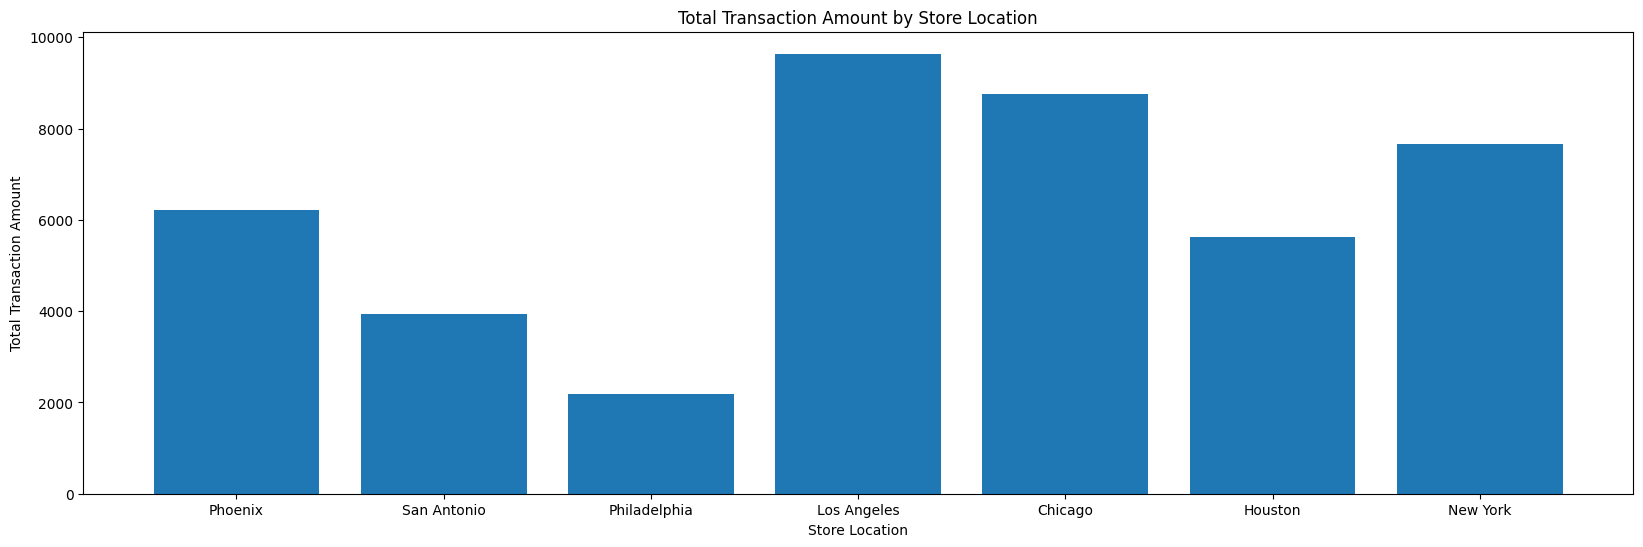

In [10]:
total_trans_by_store_pandas = total_trans_by_store.toPandas()
plt.figure(figsize=(20,6))
plt.bar(total_trans_by_store_pandas['store_location'], total_trans_by_store_pandas['sum(transaction_amount)'])
plt.xlabel('Store Location')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount by Store Location')

plt.show()

Number of transaction by store location

In [11]:
num_trans_by_store = processed_data.groupBy(col('store_location')).count()
num_trans_by_store.show()

+--------------+-----+
|store_location|count|
+--------------+-----+
|       Phoenix|   13|
|   San Antonio|   12|
|  Philadelphia|    6|
|   Los Angeles|   19|
|       Chicago|   17|
|       Houston|   15|
|      New York|   14|
+--------------+-----+



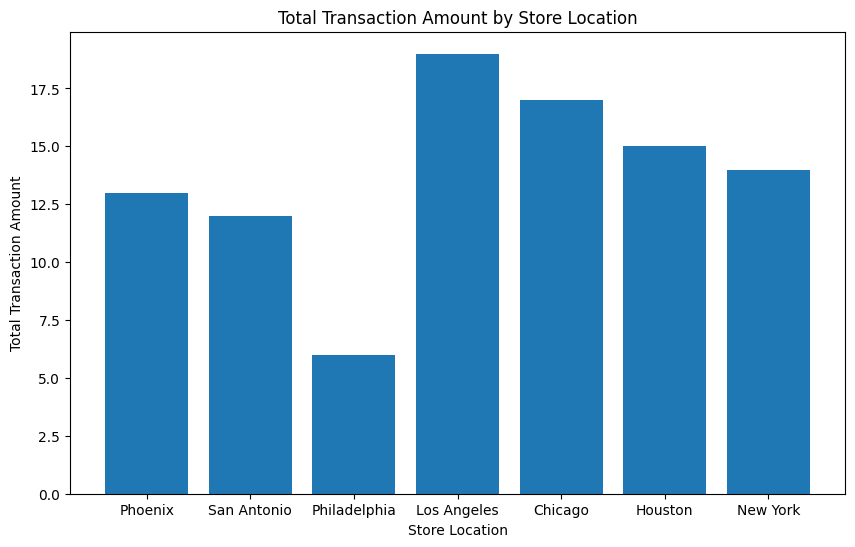

In [12]:
num_trans_by_store_pandas = num_trans_by_store.toPandas()

plt.figure(figsize=(10,6))
plt.bar(num_trans_by_store_pandas['store_location'], num_trans_by_store_pandas['count'])
plt.xlabel('Store Location')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount by Store Location')

plt.show()

Top N products by transaction amounts

In [13]:
top_prod_by_sales_amount = processed_data.groupBy(col('product_Id')).agg(sum('transaction_amount').alias('total_sales_amount'))
top_prod_by_sales_amount = top_prod_by_sales_amount.orderBy(col('total_sales_amount').desc())
top_ten_prods = top_prod_by_sales_amount.limit(10)

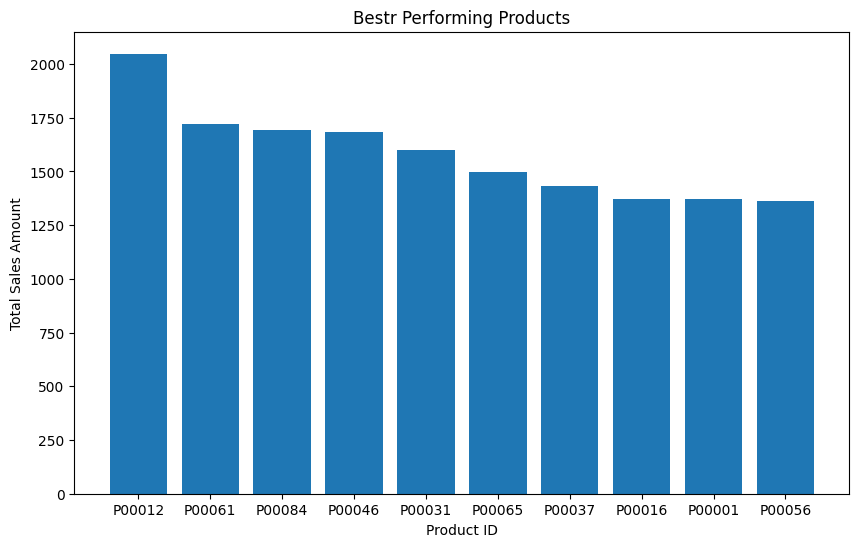

In [14]:
top_ten_prods_pandas = top_ten_prods.toPandas()

plt.figure(figsize=(10,6))
plt.bar(top_ten_prods_pandas['product_Id'], top_ten_prods_pandas['total_sales_amount'])
plt.xlabel('Product ID')
plt.ylabel('Total Sales Amount')
plt.title('Bestr Performing Products')

plt.show()

## Time Series Plots

Transaction counts over time

In [19]:
num_trans_per_min = processed_data.groupBy(window("time_of_purchase", "1 minute").alias('time')).count()
num_trans_per_min = num_trans_per_min.orderBy(col('time').asc())
num_trans_per_min.show()

+--------------------+-----+
|                time|count|
+--------------------+-----+
|{2023-12-13 15:30...|   14|
|{2023-12-13 15:31...|   29|
|{2023-12-13 15:32...|   34|
|{2023-12-13 15:33...|   29|
|{2023-12-13 15:34...|   28|
+--------------------+-----+



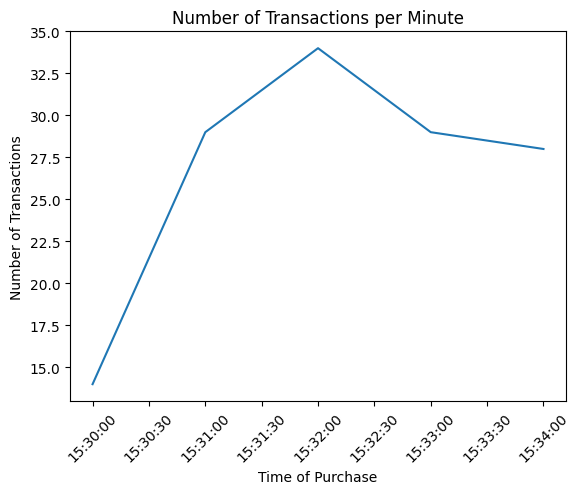

In [20]:
# Convert to Pandas DataFrame for plotting
num_trans_per_min_pandas = num_trans_per_min.toPandas()

# Extract the start of the time window for plotting
num_trans_per_min_pandas['time_start'] = num_trans_per_min_pandas['time'].apply(lambda x: x.start)

# Plotting
plt.plot(num_trans_per_min_pandas['time_start'], num_trans_per_min_pandas['count'])
plt.xlabel('Time of Purchase')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Minute')
plt.xticks(rotation=45)
plt.show()


total transactions over time

In [21]:
# Assuming 'processed_data' is your PySpark DataFrame
window_spec = Window.orderBy('time_of_purchase').rowsBetween(Window.unboundedPreceding, Window.currentRow)
processed_data_with_total = processed_data.withColumn('total_transaction_amount', F.sum('transaction_amount').over(window_spec))

processed_data_with_total.show()

23/12/13 15:35:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:35:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:35:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+-------------------+----------+------------------+------------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|total_transaction_amount|
+--------------+-------------------+----------+------------------+------------------------+
|   Los Angeles|2023-12-13 15:30:32|    P00008|               786|                     786|
|   Los Angeles|2023-12-13 15:30:33|    P00001|               633|                    1419|
|       Phoenix|2023-12-13 15:30:36|    P00031|               119|                    1538|
|       Houston|2023-12-13 15:30:37|    P00099|               162|                    1700|
|   Los Angeles|2023-12-13 15:30:39|    P00085|               815|                    2515|
|   Los Angeles|2023-12-13 15:30:41|    P00012|               767|                    3282|
|       Houston|2023-12-13 15:30:42|    P00036|              -121|                    3161|
|  Philadelphia|2023-12-13 15:30:45|    P00068|               154|              

23/12/13 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/12/13 15:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/13 15:36:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


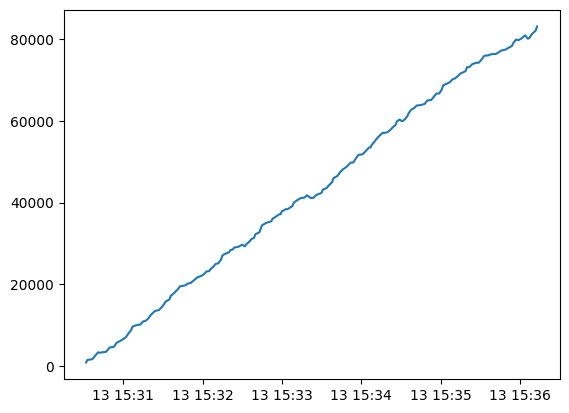

In [22]:
processed_data_with_total_pandas = processed_data_with_total.toPandas()

plt.plot(processed_data_with_total_pandas['time_of_purchase'], processed_data_with_total_pandas['total_transaction_amount'])
plt.show()

## Box Plots

Distribution of transaction amounts by store location to identify variability and outliers.


<Figure size 1000x600 with 0 Axes>

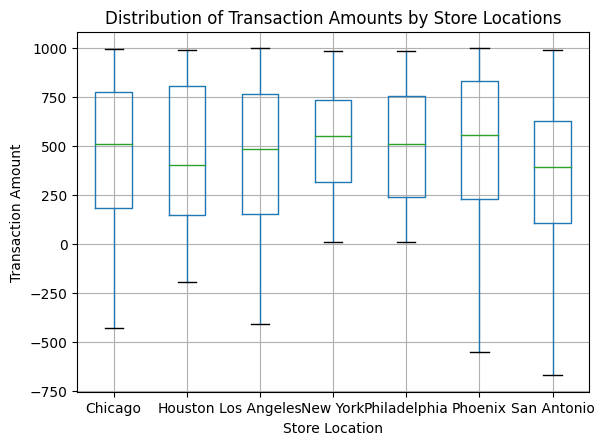

In [25]:
boxplot_data = processed_data.select("store_location", "transaction_amount").toPandas()

# Create a box plot using Matplotlib
plt.figure(figsize=(10, 6))
boxplot = boxplot_data.boxplot(by='store_location', column='transaction_amount', showfliers=False)
plt.xlabel('Store Location')
plt.ylabel('Transaction Amount')
plt.title('Distribution of Transaction Amounts by Store Locations')
plt.suptitle('')  # Remove the automatically generated title
plt.show()

## Heatmap 

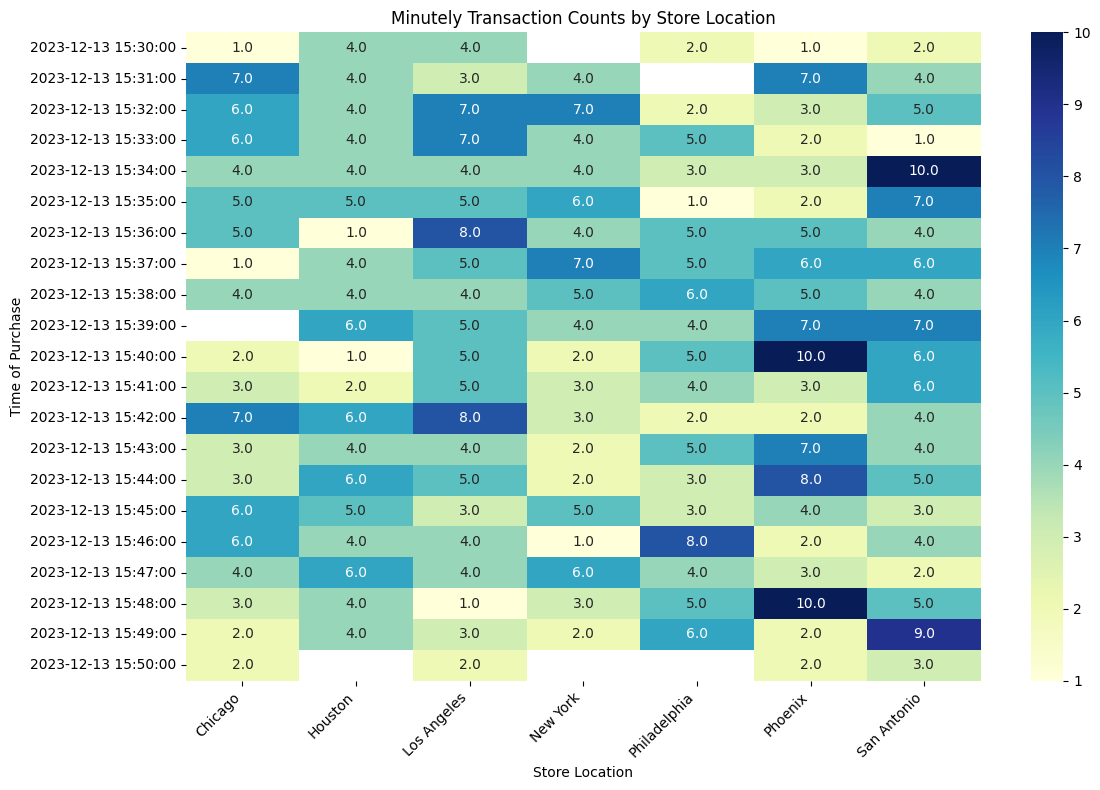

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col, date_format
import matplotlib.dates as mdates


# Assuming 'processed_data' is your PySpark DataFrame
# Replace these with your actual column names
heatmap_data = processed_data.groupBy(window("time_of_purchase", "1 minute").alias('time'), col('store_location')).count()
heatmap_data = heatmap_data.withColumnRenamed('count', 'transaction_count')

# Extract the start of the time window and format as a string
heatmap_data = heatmap_data.withColumn('time_start', date_format(col('time.start'), 'yyyy-MM-dd HH:mm:ss'))

# Convert to Pandas DataFrame for plotting
heatmap_data_pandas = heatmap_data.toPandas()

# Pivot the DataFrame to create a matrix suitable for a heatmap
heatmap_matrix = heatmap_data_pandas.pivot(index='time_start', columns='store_location', values='transaction_count')

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_matrix, cmap='YlGnBu', annot=True, fmt=".1f")  # Use ".1f" for one decimal place

# Format the time axis
plt.xticks(rotation=45, ha='right')

plt.xlabel('Store Location')
plt.ylabel('Time of Purchase')
plt.title('Minutely Transaction Counts by Store Location')
plt.tight_layout()  # Adjust layout for better display
plt.show()
